In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import joblib


 2. Preprocessing Setup

In [4]:
df = pd.read_csv('../fake_job_postings.csv')

text_features = ['description', 'requirements', 'company_profile', 'benefits']
structured_features = ['location', 'department', 'salary_range', 'telecommuting',
                       'has_company_logo', 'has_questions', 'employment_type',
                       'required_experience', 'required_education', 'industry', 'function']

# Target
target = 'fraudulent'


In [5]:
for col in text_features:
    df[col] = df[col].fillna("")


In [6]:
X = df[text_features + structured_features]
y = df[target]


3. Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


 4. Build Preprocessing Pipelines

In [8]:
numeric_imputer = SimpleImputer(strategy='most_frequent')
categorical_encoder = OneHotEncoder(handle_unknown='ignore')

structured_pipeline = Pipeline([
    ('imputer', numeric_imputer),
    ('encoder', categorical_encoder)
])


In [9]:
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=500, stop_words='english'))
])


5. Combine All with ColumnTransformer

In [10]:
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'description'),
    ('struct', structured_pipeline, structured_features)
])


 6. Random Forest Classifier Pipeline

In [11]:
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42))
])


7. Apply SMOTE to training data

In [12]:
X_train_pre = preprocessor.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_pre, y_train)

# Fit model separately (since we split preprocessing and classifier for SMOTE)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train_res, y_train_res)


c:\Users\arpit\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\arpit\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

8. Evaluate on Test Set

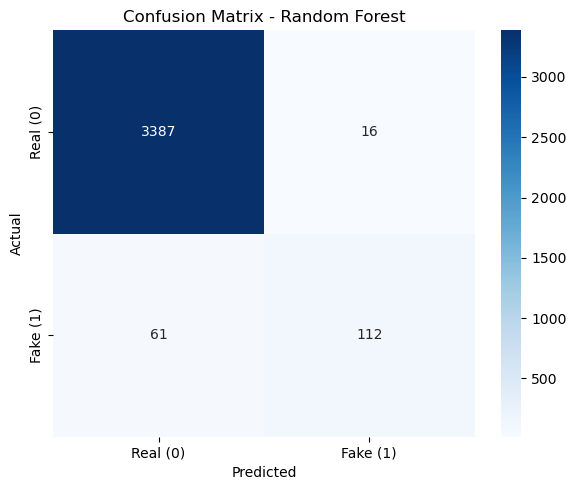

[[3387   16]
 [  61  112]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.88      0.65      0.74       173

    accuracy                           0.98      3576
   macro avg       0.93      0.82      0.87      3576
weighted avg       0.98      0.98      0.98      3576

ROC AUC: 0.9714396851469036


In [17]:
X_test_pre = preprocessor.transform(X_test)
y_pred = rf_model.predict(X_test_pre)


# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Real (0)', 'Fake (1)']

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test_pre)[:, 1]))


In [15]:
joblib.dump(rf_model, '../models/rf_model.pkl')
joblib.dump(preprocessor, '../models/rf_preprocessor.pkl')


['../models/rf_preprocessor.pkl']